### Import Necessary Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data Collection

In [2]:
path = r"/kaggle/input/adni-extracted-axial/Axial"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [3]:
class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [4]:
label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

{0: 'AD', 1: 'CI', 2: 'CN'}


In [5]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")
    
print(X.shape, y.shape)

(5154, 128, 128, 3) (5154,)


In [6]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)

(5154, 128, 128, 1)


### Data Visualization

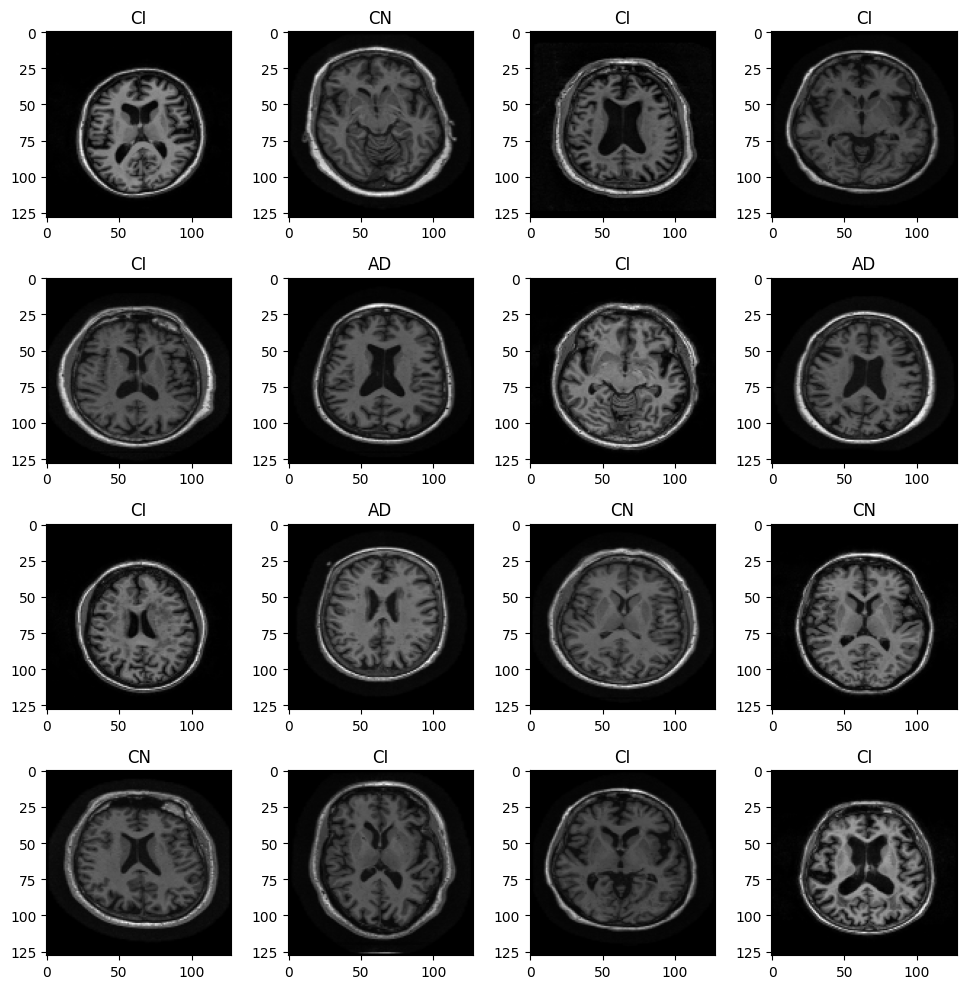

In [12]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.savefig("image_sample.png")
plt.show()

CI


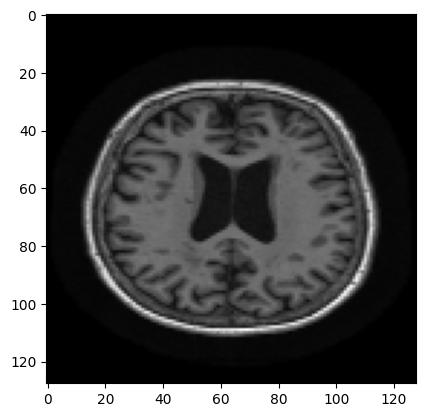

CN


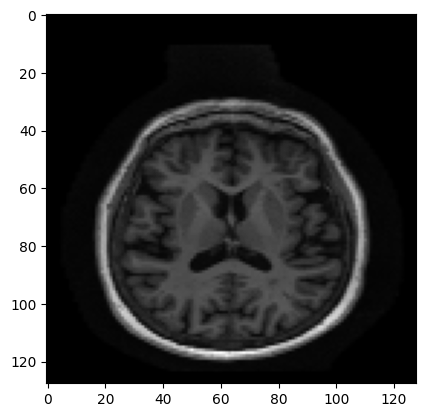

AD


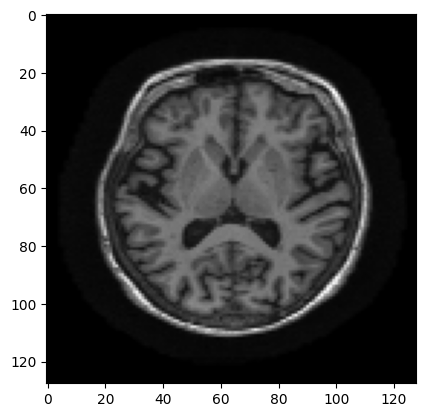

In [8]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()

In [13]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
2    1440
0    1124
Name: count, dtype: int64


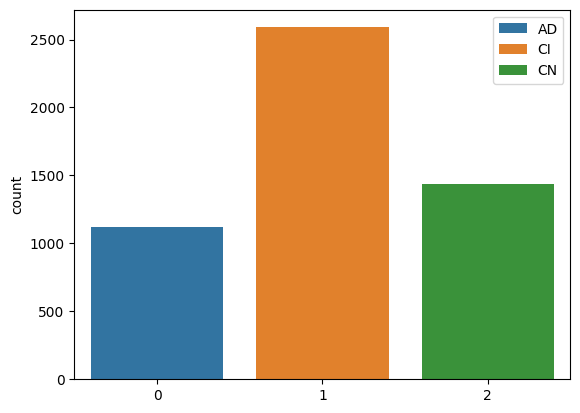

In [14]:
sns.countplot(x = y, label = label_map.values())
plt.legend()
plt.savefig("class_data_length.png")
plt.show()

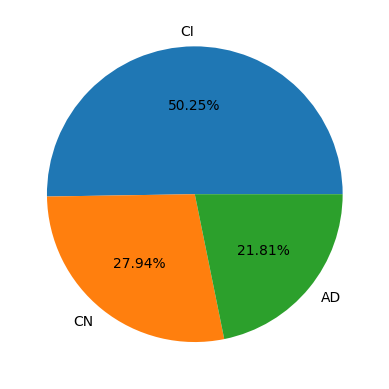

In [15]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()


### Data Augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
])

In [17]:
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count > max_total - label_counts[label]:
            break
        for i in range(2):
            augmented_img = data_augmentation(img)
            X_new.append(augmented_img)
            y_new.append(label)
            count += 1
        
X_new, y_new = np.array(X_new), np.array(y_new)
print(X_new.shape, y_new.shape)

(3852, 128, 128, 1) (3852,)


In [18]:
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

print(X.shape, y.shape)

(9006, 128, 128, 1) (9006,)


In [19]:
print(pd.Series(y).value_counts())

1    3002
2    3002
0    3002
Name: count, dtype: int64


### Data Preprocessing and Preparation

In [20]:
# Min-Max Normalization

X = X / 255.0

print(X.min(), X.max())

0.0 0.9921568627450981


In [21]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.15, 
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.15, 
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(6506, 128, 128, 1) (1149, 128, 128, 1) (1351, 128, 128, 1)
Total instances: 9006
Train instances: 6506           
Validation instances: 1149
Test instances: 1351


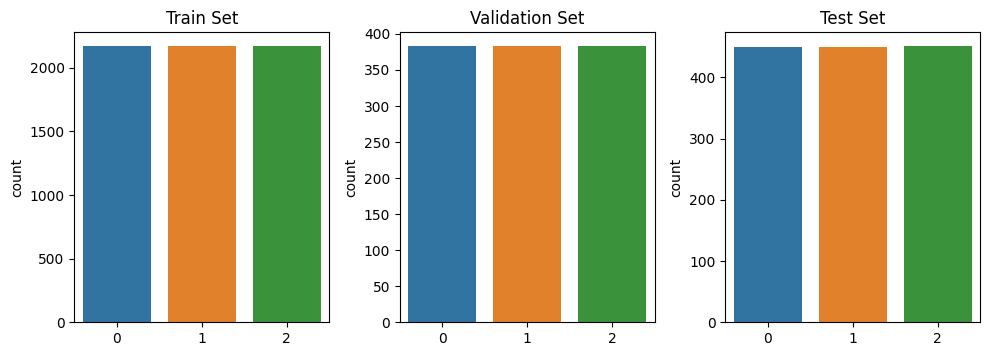

In [22]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.tight_layout()
plt.show()

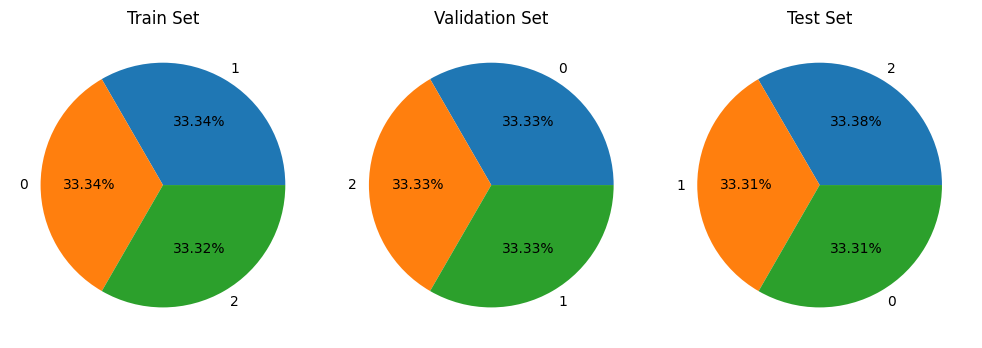

In [23]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.savefig("balance_data.png")
plt.show()

### Model Building and Training

In [24]:
# Model building

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 200, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 100, activation = "relu"),
    tf.keras.layers.Dense(units = 50, activation = "relu"),
    tf.keras.layers.Dense(units = 3, activation = "softmax")
])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 200)     2000      
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 200)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 100)       180100    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 100)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 16900)             0         
                                                                 
 dense (Dense)               (None, 100)              

In [26]:
for idx, layer in enumerate(model.layers):
    print(f"Layer {idx}:", layer.name, layer.output_shape, layer.count_params())

Layer 0: conv2d (None, 126, 126, 200) 2000
Layer 1: max_pooling2d (None, 42, 42, 200) 0
Layer 2: conv2d_1 (None, 40, 40, 100) 180100
Layer 3: max_pooling2d_1 (None, 13, 13, 100) 0
Layer 4: flatten (None, 16900) 0
Layer 5: dense (None, 100) 1690100
Layer 6: dense_1 (None, 50) 5050
Layer 7: dense_2 (None, 3) 153


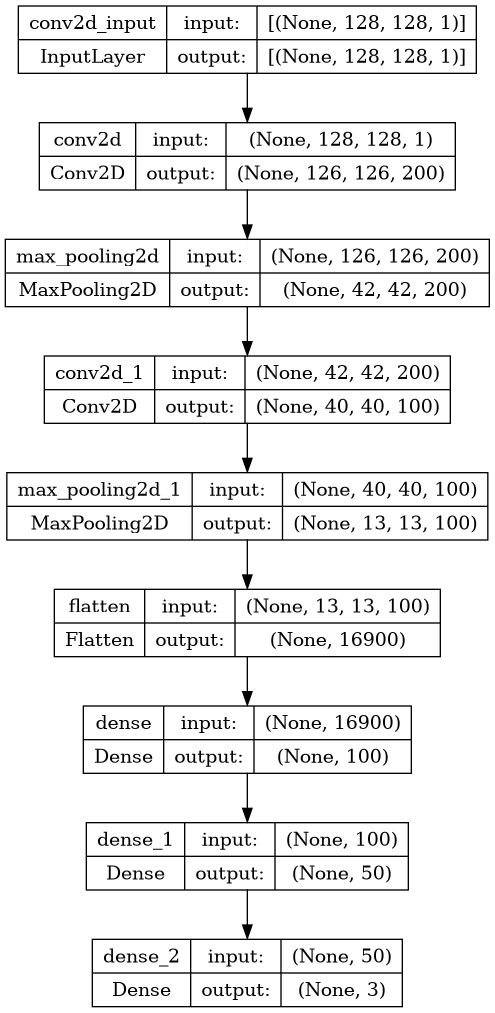

In [27]:
model_arch = tf.keras.utils.plot_model(model, show_shapes = True, to_file='model_architecture.png')
model_arch

In [28]:
# Model compilation

model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])

In [29]:
cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.h5", save_best_only = True)
cb2 = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 100, callbacks = [cb1, cb2], validation_data = (X_val, y_val))

Epoch 1/100
204/204 [==============================] - 10s 27ms/step - loss: 0.9859 - accuracy: 0.4889 - val_loss: 0.7600 - val_accuracy: 0.6667
Epoch 2/100
204/204 [==============================] - 5s 24ms/step - loss: 0.5292 - accuracy: 0.7853 - val_loss: 0.4374 - val_accuracy: 0.8138
Epoch 3/100
204/204 [==============================] - 5s 23ms/step - loss: 0.2722 - accuracy: 0.8981 - val_loss: 0.2445 - val_accuracy: 0.9077
Epoch 4/100
204/204 [==============================] - 5s 23ms/step - loss: 0.1537 - accuracy: 0.9490 - val_loss: 0.1287 - val_accuracy: 0.9652
Epoch 5/100
204/204 [==============================] - 5s 23ms/step - loss: 0.0978 - accuracy: 0.9697 - val_loss: 0.1547 - val_accuracy: 0.9565
Epoch 6/100
204/204 [==============================] - 5s 23ms/step - loss: 0.0914 - accuracy: 0.9702 - val_loss: 0.1293 - val_accuracy: 0.9591
Epoch 7/100
204/204 [==============================] - 5s 23ms/step - loss: 0.0455 - accuracy: 0.9854 - val_loss: 0.1739 - val_accuracy

In [30]:
result_df = pd.DataFrame(history.history)
result_df.head()

loss  accuracy  val_loss  val_accuracy
0  0.985887  0.488933  0.759976      0.666667
1  0.529176  0.785275  0.437357      0.813751
2  0.272247  0.898094  0.244537      0.907746
3  0.153710  0.948970  0.128721      0.965187
4  0.097842  0.969720  0.154725      0.956484

In [31]:
result_df.describe()

loss   accuracy   val_loss  val_accuracy
count  15.000000  15.000000  15.000000     15.000000
mean    0.161124   0.931110   0.188098      0.934784
std     0.266123   0.134276   0.182933      0.085773
min     0.003659   0.488933   0.069162      0.666667
25%     0.026255   0.959345   0.091621      0.953873
50%     0.060898   0.978481   0.128721      0.965187
75%     0.125776   0.991854   0.164309      0.976936
max     0.985887   0.998924   0.759976      0.983464

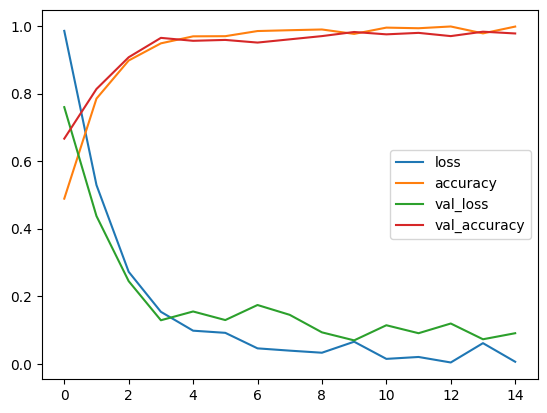

In [32]:
# Learning curves

result_df.plot()
plt.savefig("model_learnign_curve.png")
plt.show()

In [33]:
# Evaluating the model on train set

loss, acc = model.evaluate(X_train, y_train)

204/204 [==============================] - 1s 7ms/step - loss: 0.0093 - accuracy: 0.9983


In [35]:
# Confusion Matrix

y_train_pred = model.predict(X_train)
y_train_pred_labels = np.array([np.argmax(y_) for y_ in y_train_pred])

cm = tf.math.confusion_matrix(labels = y_train, predictions = y_train_pred_labels)
print(cm)

204/204 [==============================] - 1s 6ms/step
tf.Tensor(
[[2169    0    0]
 [   2 2160    7]
 [   1    1 2166]], shape=(3, 3), dtype=int32)


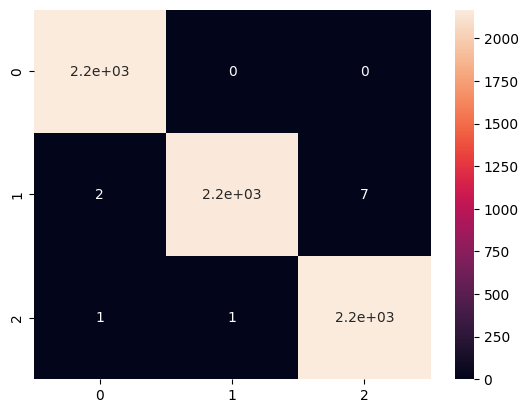

In [36]:
sns.heatmap(cm, annot = True)
plt.savefig("confusion_matrix_train.png")
plt.show()

In [37]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")
    
describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 2169
True Negatives : 4334
False Positives : 3
False Negatives : 0

Precision : 0.9986187845303868
Recall (Sensitivity) : 1.0
F1-Score : 0.9993089149965445


Class CI : 

True Positives : 2160
True Negatives : 4336
False Positives : 1
False Negatives : 9

Precision : 0.999537251272559
Recall (Sensitivity) : 0.995850622406639
F1-Score : 0.9976905311778291


Class CN : 

True Positives : 2166
True Negatives : 4331
False Positives : 7
False Negatives : 2

Precision : 0.9967786470317533
Recall (Sensitivity) : 0.9990774907749077
F1-Score : 0.9979267449896337


In [40]:
# Classification Report
# Define the list of label names
label_names = ['AD', 'CI', 'CN']
clf_report = metrics.classification_report(y_train, y_train_pred_labels, target_names=label_names)
print(clf_report)

              precision    recall  f1-score   support

          AD       1.00      1.00      1.00      2169
          CI       1.00      1.00      1.00      2169
          CN       1.00      1.00      1.00      2168

    accuracy                           1.00      6506
   macro avg       1.00      1.00      1.00      6506
weighted avg       1.00      1.00      1.00      6506



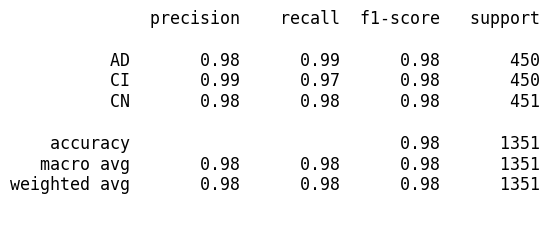

In [51]:
# Function to save the classification report as an image
def save_classification_report_as_image(report, filename):
    # Split the classification report into lines
    lines = report.split('\n')
    
    # Create a figure and axis to plot the text
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.axis('off')
    
    # Add the report text to the plot
    plt.text(0, 1, report, fontsize=12, fontname='monospace', verticalalignment='top')
    
    # Save the plot as an image file
    plt.savefig(filename, bbox_inches='tight')

# Save the classification report as an image
save_classification_report_as_image(clf_report, 'classification_report_train.png')

### Model Validation

In [42]:
# Evaluating the model on test set

loss, acc = model.evaluate(X_test, y_test)

43/43 [==============================] - 0s 8ms/step - loss: 0.2370 - accuracy: 0.9800


43/43 [==============================] - 0s 6ms/step


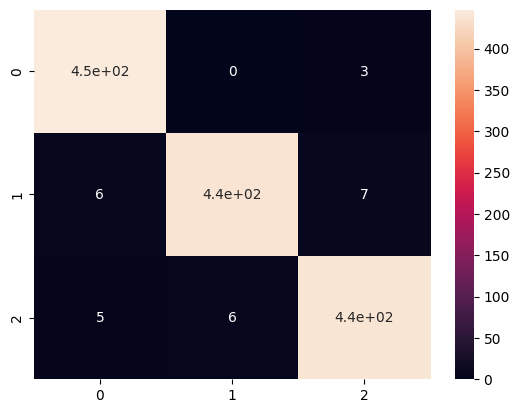

In [43]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.savefig("test_confusion_matrix.png")
plt.show()

In [44]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")
    
describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 447
True Negatives : 890
False Positives : 11
False Negatives : 3

Precision : 0.9759825327510917
Recall (Sensitivity) : 0.9933333333333333
F1-Score : 0.9845814977973568


Class CI : 

True Positives : 437
True Negatives : 895
False Positives : 6
False Negatives : 13

Precision : 0.9864559819413092
Recall (Sensitivity) : 0.9711111111111111
F1-Score : 0.9787234042553191


Class CN : 

True Positives : 440
True Negatives : 890
False Positives : 10
False Negatives : 11

Precision : 0.9777777777777777
Recall (Sensitivity) : 0.975609756097561
F1-Score : 0.97669256381798


In [46]:
# Classification Report
label_names = ['AD', 'CI', 'CN']
clf_report_test = metrics.classification_report(y_test, y_test_pred_labels, target_names=label_names)
print(clf_report_test)

              precision    recall  f1-score   support

          AD       0.98      0.99      0.98       450
          CI       0.99      0.97      0.98       450
          CN       0.98      0.98      0.98       451

    accuracy                           0.98      1351
   macro avg       0.98      0.98      0.98      1351
weighted avg       0.98      0.98      0.98      1351



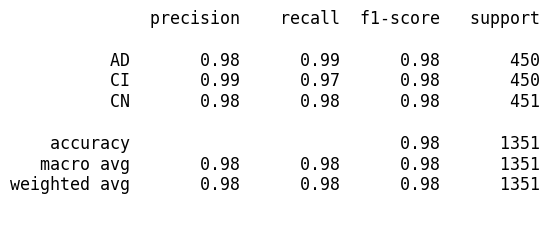

In [52]:
# Save the classification report as an image
save_classification_report_as_image(clf_report_test, 'classification_report.png')

### Saving the Model

In [53]:
model.save("clf_model_final.h5")